# EDA Features per station
Purpose of this notebook is to show an analysis of the relation between the line, station and features and to find out whether there is a trend between the Reponse and the line, station or feature.

Observation from features per station:
- The number of features differs per line, station
- Couple of features have the wrong labels
- 50%-70% of features do not have a timestamp feature
- Some (~30) timestamp features colums do not exist in numeric or categorical train sets
    
Observations numeric features:
 - 48% of stations have all timestamps of numeric features
 - 44% of stations have zero timestamps of numeric features
 - 8% of stations has between 23% and 50% timestamps

Observations categorical features:
 - 35% of stations have no categorical features
 - 21% of stations with categorical features have 50% timestamps
 - 5% of stations with categorical features have 0% timestamps
 
Observation faulty vs. non-faulty:
 - Most stations are passed by the same amount (relatively) of faulty and non-faulty products.
 - Couple of stations have significant more faulty products -> this suggests at least a correlation!
 - The numeric values of the train data have approx zero mean for alle stations for non-faulty product. Several stations have non-zero mean for faulty products.
 - The variance of the numeric values of the train data is slightly lower for faulty products than non-faulty products. 

In [222]:
from __future__ import print_function


import os
import re
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Custom modules
import const
import func

## Load data
Line, station, feature info is extracted from the column labels in the train data sets. Output is three dataframes with the line, station and feature_nr for each of the train data sets.

In [153]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [154]:
[num_info, cat_info, date_info] = [func.get_station_info(f) for f in const.TRAIN_FILES]

# Date features refer to numeric/categorical features
date_info['ref_feat_nr'] = date_info['feature_nr'] - 1

In [155]:
cat_info.head()

,line,station,feature_nr,name
0,0,1,25,L0_S1_F25
1,0,1,27,L0_S1_F27
2,0,1,29,L0_S1_F29
3,0,1,31,L0_S1_F31
4,0,2,33,L0_S2_F33


### Analyze and aggregate line/station info
Aggregate on line & station level to get an idea of distribution of features over the different lines. First count the number of features per line for each of the datasets.

In [6]:
# Number of stations differs per line, so lines are different
num_info.line.value_counts()

1    513
3    245
0    168
2     42
Name: line, dtype: int64

In [7]:
cat_info.line.value_counts()

1    1227
3     431
0     323
2     159
Name: line, dtype: int64

In [8]:
date_info.line.value_counts()

1    621
3    273
0    184
2     78
Name: line, dtype: int64

The date set has more features than the numeric, but less than the categorical. This means that a significant amount of the features has no timestamp. Questions is why and can the missing timestamps be imputed? Some lines have significant more features than others. This question will be further analyze below.

First create an aggregated dataframe with the feature count of each dataset per line and per station.

In [9]:
station_info = pd.concat([num_info.groupby(['line','station']).feature_nr.agg({'n_feat_num':'count'}),
                        cat_info.groupby(['line','station']).feature_nr.agg({'n_feat_cat':'count'}),
                        date_info.groupby(['line','station']).feature_nr.agg({'n_feat_date':'count'})],
                       axis=1).fillna(0)
station_info.head()                    

n_feat_num  n_feat_cat  n_feat_date
line station                                     
0    0              12.0         0.0           12
     1               2.0         4.0            2
     2               9.0        18.0            9
     3               9.0        18.0            9
     4               2.0         6.0            2

### Why are there sometimes more date features than numeric features?

Take as first example line number 0 and station number 6.

This station has 3 numeric features, 10 categorical features, but only five date features that all refer to the categorical features. The date features skip one feature every time, so that might be a clue that this info can be imputed. No timestamps from the numeric available for this station.

In [16]:
line_nr = 0
stat_nr = 6
print 'Numeric features'
print num_info[ (num_info.line==line_nr) & (num_info.station==stat_nr)]
print 'Categorical features'
print cat_info[ (cat_info.line==line_nr) & (cat_info.station==stat_nr)]
print 'Date features'
print date_info[ (date_info.line==line_nr) & (date_info.station==stat_nr)]

Numeric features
    line  station  feature_nr
36     0        6         118
37     0        6         122
38     0        6         132
Categorical features
    line  station  feature_nr
46     0        6         119
47     0        6         121
48     0        6         123
49     0        6         125
50     0        6         126
51     0        6         128
52     0        6         129
53     0        6         131
54     0        6         133
55     0        6         135
Date features
    line  station  feature_nr  ref_feat_nr
36     0        6         120          119
37     0        6         124          123
38     0        6         127          126
39     0        6         130          129
40     0        6         134          133


Another, weird, example. This one has no categorical features, 4 numeric features and 6 date features. So there are more data features than numeric features? Are they maybe wrongly labeled and do they belong to a different station?

In [17]:
line_nr = 3
stat_nr = 37
print 'Numeric features'
print num_info[ (num_info.line==line_nr) & (num_info.station==stat_nr)]
print 'Categorical features'
print cat_info[ (cat_info.line==line_nr) & (cat_info.station==stat_nr)]
print 'Date features'
print date_info[ (date_info.line==line_nr) & (date_info.station==stat_nr)]

Numeric features
     line  station  feature_nr
879     3       37        3944
880     3       37        3946
881     3       37        3948
882     3       37        3950
Categorical features
Empty DataFrame
Columns: [line, station, feature_nr]
Index: []
Date features
      line  station  feature_nr  ref_feat_nr
1050     3       37        3942         3941
1051     3       37        3943         3942
1052     3       37        3945         3944
1053     3       37        3947         3946
1054     3       37        3949         3948
1055     3       37        3951         3950


In [25]:
# Check whether these features were mislabeled and maybe there are found in different stations
print num_info[num_info.feature_nr==3941]
print cat_info[cat_info.feature_nr==3941]

Empty DataFrame
Columns: [line, station, feature_nr]
Index: []
      line  station  feature_nr
2012     3       36        3941


In [26]:
# Check whether these features were mislabeled and maybe there are found in different stations
print num_info[num_info.feature_nr==3942]
print cat_info[cat_info.feature_nr==3942]

Empty DataFrame
Columns: [line, station, feature_nr]
Index: []
Empty DataFrame
Columns: [line, station, feature_nr]
Index: []


So one of them was wrongly labeled and the other is not present in all datasets. Let's get an overview on whole train set level.

In [27]:
print('Numeric: {} of {} features do not have a timestamp'. \
          format(len(set(num_info.feature_nr.values) - set(date_info.ref_feat_nr.values)),
                 num_info.shape[0]))
print('Categorical: {} of {} features do not have a timestamp'. \
          format(len(set(cat_info.feature_nr.values) - set(date_info.ref_feat_nr.values)),
                 cat_info.shape[0]))
print('Date: {} of {} features do not refer to numeric/categorical features'. \
          format(len(set(date_info.ref_feat_nr.values) - set(cat_info.feature_nr.values) - set(num_info.feature_nr.values)),
                 cat_info.shape[0]))

Numeric: 602 of 968 features do not have a timestamp
Categorical: 1381 of 2140 features do not have a timestamp
Date: 31 of 2140 features do not refer to numeric/categorical features


There are different gaps between feature numbers. Might be interesting to double check the test set.

In [38]:
# Plot value counts of gaps between feature numbers. 
pd.Series(np.diff(sorted(list(set(cat_info.feature_nr.values) & set(date_info.ref_feat_nr.values))))).value_counts()

5     437
4     176
3      73
2      20
7       7
15      6
21      4
23      4
26      3
9       3
18      3
11      2
22      2
27      2
32      1
49      1
46      1
38      1
6       1
34      1
8       1
24      1
10      1
13      1
14      1
31      1
17      1
51      1
30      1
67      1
dtype: int64

### Calculate per station amount of features with timestamp
Calculate some more information about the stations. Add the relative amount of features with timestamp for categorical and numeric timestamps features.

In [43]:
def timestap_coverage_per_station(x, date_info, num_info, cat_info):
    line_nr = x.name[0]
    station_nr = x.name[1]
    
    #print line_nr, station_nr
    feat_with_timestamp = date_info[ (date_info.line==line_nr) & (date_info.station==station_nr)].ref_feat_nr.values
    
    #print feat_with_timestamp
    num_with_timestamp = ((num_info.line==line_nr) & \
                          (num_info.station==station_nr) & \
                          (num_info.feature_nr.isin(feat_with_timestamp)))
    cat_with_timestamp = ((cat_info.line==line_nr) & \
                          (cat_info.station==station_nr) & \
                          (cat_info.feature_nr.isin(feat_with_timestamp)))
    t_without_cat_num = len(set(feat_with_timestamp) - \
                            set(num_info[num_with_timestamp].feature_nr) - \
                            set(cat_info[cat_with_timestamp].feature_nr))
    
    #print x['n_feat_num'],x['n_feat_cat']
    #print num_with_timestamp,cat_with_timestamp
    
    
    r_num = float(num_with_timestamp.sum()) / x['n_feat_num'] if x['n_feat_num']>0 else 0
    r_cat = float(cat_with_timestamp.sum()) / x['n_feat_cat'] if x['n_feat_cat']>0 else 0
    r_no = float(t_without_cat_num) 
    
    #print r_num, r_cat

    return pd.Series({'feat_cat_w_t': r_cat, 'feat_num_w_t': r_num, 'feat_t_wo_cn': r_no}).fillna(0).round(2)

In [44]:
station_info[['feat_cat_w_t','feat_num_w_t','feat_t_wo_ct']] = \
    station_info.apply(lambda x: timestap_coverage_per_station(x, date_info, num_info, cat_info), axis=1)

In [54]:
station_info.head()

n_feat_num  n_feat_cat  n_feat_date  feat_cat_w_t  feat_num_w_t  \
line station                                                                    
0    0              12.0         0.0           12          0.00           1.0   
     1               2.0         4.0            2          0.50           0.0   
     2               9.0        18.0            9          0.50           0.0   
     3               9.0        18.0            9          0.50           0.0   
     4               2.0         6.0            2          0.33           0.0   

              feat_t_wo_ct  
line station                
0    0                 0.0  
     1                 0.0  
     2                 0.0  
     3                 0.0  
     4                 0.0

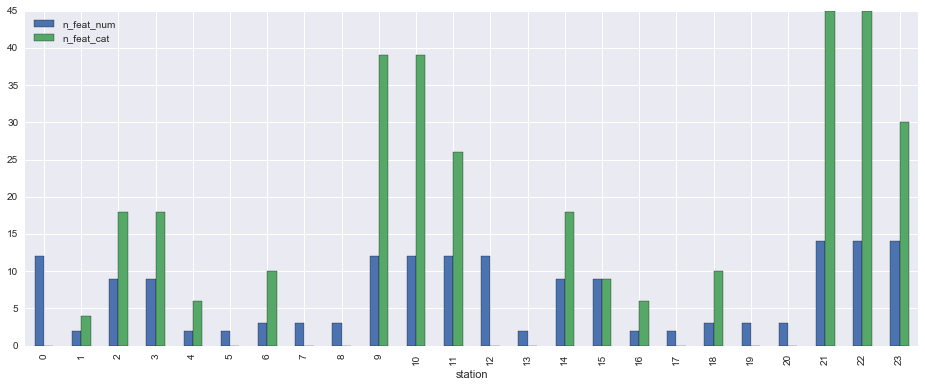

In [50]:
# Line 0
line_nr = 0
station_info.loc[line_nr,['n_feat_num','n_feat_cat']].plot(kind='bar', figsize=(16,6))
#station_info.n_feat_cat.plot(kind='bar', figsize=(16,6))

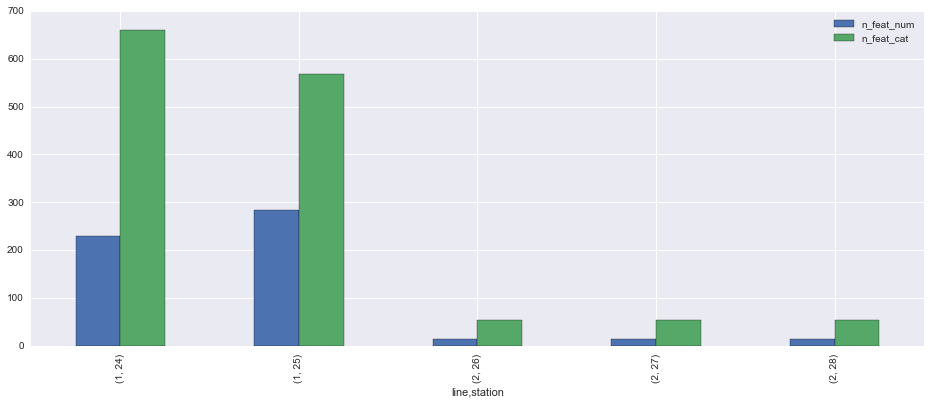

In [51]:
# Line 1 and 2
station_info.loc[1:2,['n_feat_num','n_feat_cat']].plot(kind='bar', figsize=(16,6))
#station_info.n_feat_cat.plot(kind='bar', figsize=(16,6))

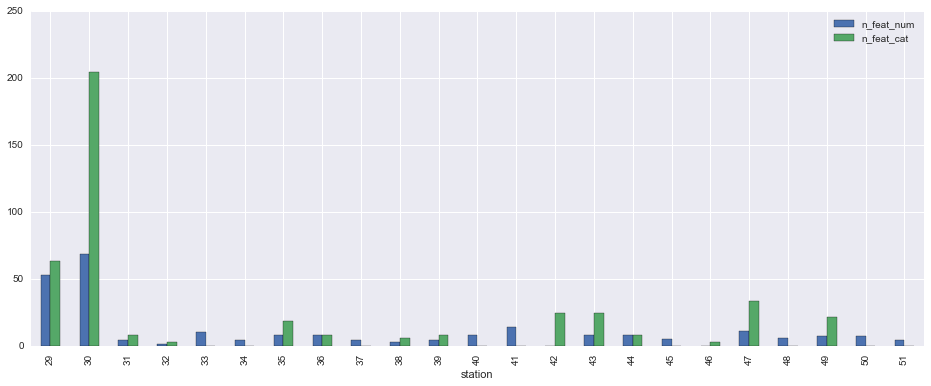

In [52]:
# Line 2 and 3
station_info.loc[3,['n_feat_num','n_feat_cat']].plot(kind='bar', figsize=(16,6))


In [55]:
station_info['feat_num_w_t'].value_counts()

1.00    25
0.00    23
0.31     1
0.23     1
0.50     1
0.25     1
Name: feat_num_w_t, dtype: int64

In [56]:
station_info.loc[station_info['n_feat_cat']>0,'feat_cat_w_t'].value_counts()

0.33    14
0.50    11
0.23     3
0.00     3
0.40     1
0.16     1
0.35     1
Name: feat_cat_w_t, dtype: int64

### Are the feature numbers consistent?

There are no common feature_nr in the three data sets...so that is consistent.

In [57]:
print(len(set(date_info.feature_nr.values) & set(cat_info.feature_nr.values)))
print(len(set(date_info.feature_nr.values) & set(num_info.feature_nr.values)))
print(len(set(num_info.feature_nr.values) & set(cat_info.feature_nr.values)))

0
0
0


The combined feature numbers increase monotomically by 1...also consistent!

In [58]:
all_feat_nr = (set(date_info.feature_nr.values) | set(cat_info.feature_nr.values) | set(num_info.feature_nr.values))

In [59]:
(max(all_feat_nr) - min(all_feat_nr) + 1) / len(all_feat_nr)

1

## Estimate number of faults per station for numeric features

In [116]:
dat_num = func.load_data_file('train_numeric')

# Get response data and ids
y = dat_num['data']['y']
ids = dat_num['data']['ids']

# Get sample nr of faulty responses
fault_ids = y[y.Response==1]
fault_sample_nr = ids[ids.Id.isin(fault_ids.index)].index.values

del dat_num

Returning <open file '/Volumes/My Book/kaggle_bosch/train_numeric.pkl', mode 'rb' at 0x1166c4420>


In [67]:
# Use SKLearn StandardScaler to efficiently get the mean and std of the values of the numeric data of each feature
all_scaler = StandardScaler(with_mean=False).fit(dat_num['data']['features'])
fault_scaler = StandardScaler(with_mean=False).fit(dat_num['data']['features'][fault_sample_nr,:])

In [88]:
num_info['prod_passed'] = np.bincount(dat_num['data']['features'].indices)
num_info['prod_passed_rel'] = num_info['prod_passed'].astype(float) / y.shape[0]
num_info['prod_passed_val_m'] = all_scaler.mean_
num_info['prod_passed_val_var'] = all_scaler.var_
num_info['prod_passed_fault'] = np.bincount(dat_num['data']['features'][fault_sample_nr,:].indices)
num_info['prod_passed_fault_rel'] = num_info['prod_passed_fault'].astype(float) / fault_ids.shape[0]
num_info['prod_passed_fault_val_m'] = fault_scaler.mean_
num_info['prod_passed_fault_val_var'] = fault_scaler.var_
num_info['ratio_fault'] = num_info['prod_passed_fault'] / num_info['prod_passed']

In [89]:
num_info.head()

,line,station,feature_nr,prod_passed,prod_passed_rel,prod_passed_val_m,prod_passed_val_std,prod_passed_fault,prod_passed_fault_rel,ratio_fault,prod_passed_fault_val_m,prod_passed_fault_val_std,prod_passed_val_var,prod_passed_fault_val_var
0,0,0,0,673862,0.569262,0.000031,0.003663,3608,0.524495,0.005354,-0.000209,0.003160,0.003663,0.003160
1,0,0,2,673862,0.569262,0.000052,0.004902,3608,0.524495,0.005354,0.000729,0.004281,0.004902,0.004281
2,0,0,4,673862,0.569262,0.000023,0.025469,3608,0.524495,0.005354,-0.016215,0.020965,0.025469,0.020965
3,0,0,6,673862,0.569262,0.000008,0.025497,3608,0.524495,0.005354,-0.016067,0.021038,0.025497,0.021038
4,0,0,8,673862,0.569262,-0.000072,0.005090,3608,0.524495,0.005354,0.001804,0.004821,0.005090,0.004821


In [90]:
num_info_agg = num_info.groupby(['line','station']).agg('mean') 

In [91]:
num_info_agg.head()

feature_nr    prod_passed  prod_passed_rel  prod_passed_val_m  \
line station                                                                  
0    0              11.0  665674.833333         0.562346           0.000019   
     1              26.0  672599.500000         0.568195          -0.000029   
     2              48.0  296767.666667         0.250702           0.000048   
     3              84.0  292991.333333         0.247512          -0.000005   
     4             106.5  326761.000000         0.276040           0.000006   

              prod_passed_val_std  prod_passed_fault  prod_passed_fault_rel  \
line station                                                                  
0    0                   0.012329        3563.583333               0.518038   
     1                   0.006292        3601.500000               0.523550   
     2                   0.006305        1587.777778               0.230815   
     3                   0.006575        1565.222222               0.227536   
     4                   0.000479        1764.500000               0.256505   

              ratio_fault  prod_passed_fault_val_m  prod_passed_fault_val_std  \
line station                                                                    
0    0           0.005353                -0.003861                   0.010959   
     1           0.005355                -0.000446                   0.005361   
     2           0.004756                 0.000241                   0.005858   
     3           0.004748                -0.000155                   0.006070   
     4           0.005401                -0.001592                   0.000596   

              prod_passed_val_var  prod_passed_fault_val_var  
line station                                                  
0    0                   0.012329                   0.010959  
     1                   0.006292                   0.005361  
     2                   0.006305                   0.005858  
     3                   0.006575                   0.006070  
     4                   0.000479                   0.000596

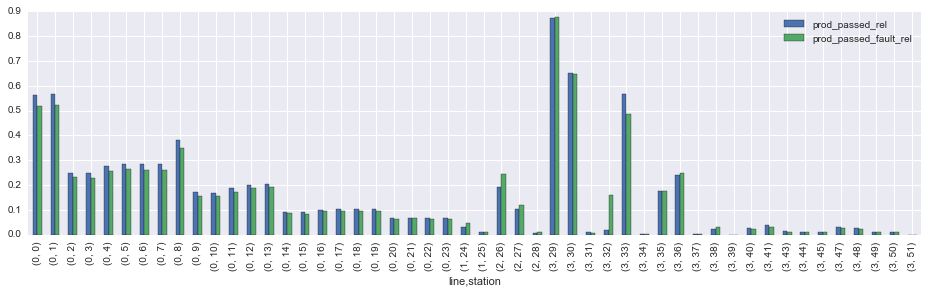

In [92]:
# The plot below shows the relative amount of faulty and non-faulty products that passed this station. Mostly equal,
# but Station 32 on line 3 is interesting. This means the almost all products that passed this station are faulty.
# Couple of stations have higher ratio.
num_info_agg[['prod_passed_rel','prod_passed_fault_rel']].plot(kind='bar', figsize=(16,4))

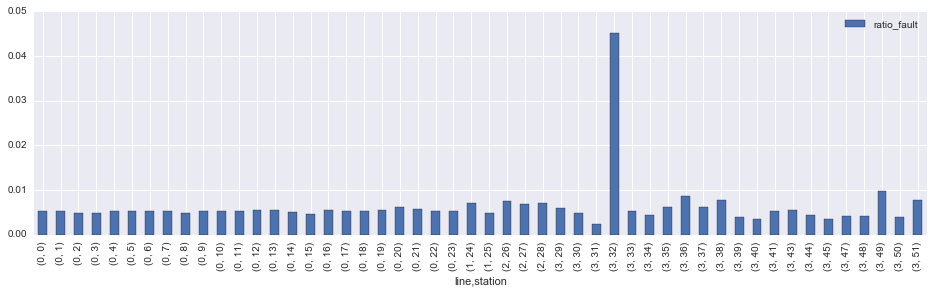

In [97]:
# Next plot shows the ratio of faulty versus non-faulty products. One station looks different...
num_info_agg[['ratio_fault']].plot(kind='bar', figsize=(16,4))

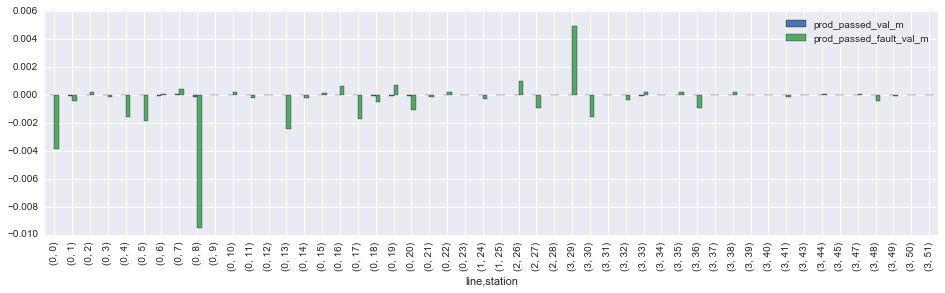

In [93]:
# The plot below shows the mean of the value of for faulty and non-faulty products. Almost all stations have zero mean
# for non-faulty products, but non-zero mean for faulty products. Potentially interesting feature!
num_info_agg[['prod_passed_val_m','prod_passed_fault_val_m']].plot(kind='bar', figsize=(16,4))

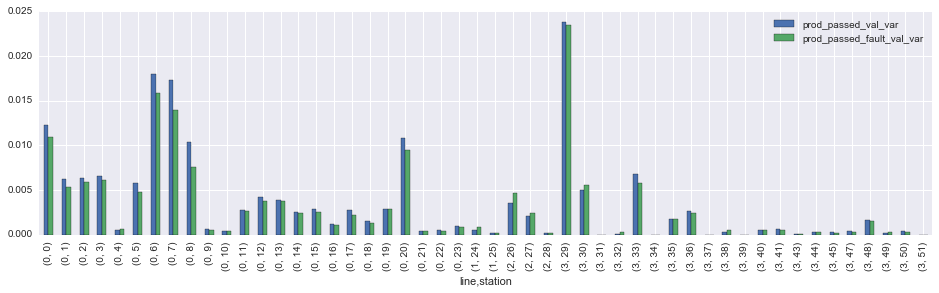

In [96]:
# The plot below shows the variance of the numerical value for faulty and non-faulty products per station.
# Weird that faulty products have a lower variance than non-faulty, I would expect the other way around.
num_info_agg[['prod_passed_val_var','prod_passed_fault_val_var']].plot(kind='bar', figsize=(16,4))

## Estimate number of faults per station for categorical features

In [10]:
dat_cat = func.load_data_file('train_categorical_to_num')

y = dat_cat['data']['y']
ids = dat_cat['data']['ids']

del dat_cat

Returning <open file '/Volumes/My Book/kaggle_bosch/train_categorical_to_num.pkl', mode 'rb' at 0x115dc6ae0>


In [120]:
#dat_cat = func.load_data_file('train_categorical_to_num','csv')
dat_cat = pd.read_csv(os.path.join(const.BASE_PATH, 'train_categorical_to_num.csv'), index_col=0)

In [121]:
def calculate_cat_level_properties(x):
    
    # Do not consider missing data
    x = x[~x.isnull()]
    x_f = x.iloc[:10]
    
    output = {'unique': str(x.unique()),
              'nunique': x.nunique(),
              'val_most_common': most_common_value(x),
              'unique_fault': str(x_f.unique()),
             'nunique_fault': x_f.nunique(),
             'val_most_common_fault': most_common_value(x_f)}
    
    return pd.Series(output)

def most_common_value(x):
    sc = x.value_counts()
    
    if sc.shape[0]>0:
        return sc.index[0]
    else:
        return np.nan

In [122]:
cat_info2 = dat_cat.apply(lambda x: calculate_cat_level_properties(x)).transpose()

In [131]:
cat_info2['nunique_diff'] = cat_info2['nunique'] - cat_info2['nunique_fault'] 
#cat_info2['same_most_common'] = (cat_info2['val_most_common'] == cat_info2['val_most_common_fault']).astype(int)
cat_info2['different_most_common'] = (cat_info2['val_most_common'] != cat_info2['val_most_common_fault']).astype(int)
cat_info2['prod_passed'] = dat_cat.count(0)
cat_info2['prod_passed_rel'] = cat_info2['prod_passed'].astype(float) / y.shape[0]
cat_info2['prod_passed_fault'] = dat_cat.iloc[fault_sample_nr,:].count(0)
cat_info2['prod_passed_fault_rel'] = cat_info2['prod_passed_fault'].astype(float) / fault_ids.shape[0]
cat_info2['ratio_fault'] = cat_info2['prod_passed_fault_rel'] / cat_info2['prod_passed_rel']

In [160]:
cat_info = cat_info.merge(cat_info2, left_on='name', right_index=True, how='left')

In [162]:
print('Number of features: {}'.format(cat_info.shape[0]))
print('Features with different most common level: {}'.format(cat_info['different_most_common'].sum()))
print('Categorical features without Response=1: {}'.format((cat_info.prod_passed_fault==0).sum()))
print('Categorical features (with at least one sample Response=1) and different most common level: {}'. \
      format(cat_info[cat_info.prod_passed_fault>0]['different_most_common'].sum()))
print('Categorical features (with at least ten samples Response=1) and different most common level: {}'. \
      format(cat_info[cat_info.prod_passed_fault>10]['different_most_common'].sum()))
print('Features with only one level: {}'.format((cat_info.nunique==1).sum()))
print('Levels found in non-faulty: {}'.format(cat_info['nunique'].sum()))
print('Levels not found in faulty: {}'.format(cat_info['nunique_diff'].sum()))

Number of features: 2140
Features with different most common level: 261
Categorical features without Response=1: 1431
Categorical features (with at least one sample Response=1) and different most common level: 10
Categorical features (with at least ten samples Response=1) and different most common level: 1
Features with only one level: 1549
Levels found in non-faulty: 4258
Levels not found in faulty: 1234


In [ ]:
cat_info

In [163]:
cat_info.sample(10)

,line,station,feature_nr,name,nunique,nunique_fault,unique,unique_fault,val_most_common,val_most_common_fault,nunique_diff,same_most_common,prod_passed,prod_passed_rel,prod_passed_fault,prod_passed_fault_rel,ratio_fault,different_most_common
1535,1,25,2973,L1_S25_F2973,1,1,[ 1.],[ 1.],1,1,0,1,6955,0.005875,24,0.003489,0.593810,0
596,1,24,1156,L1_S24_F1156,1,1,[ 1.],[ 1.],1,1,0,1,26812,0.022650,200,0.029074,1.283614,0
1288,1,25,2470,L1_S25_F2470,1,1,[ 1.],[ 1.],1,1,0,1,78,0.000066,0,0.000000,0.000000,0
1751,3,29,3435,L3_S29_F3435,1,1,[ 1.],[ 1.],1,1,0,1,785437,0.663518,4571,0.664486,1.001460,0
1884,3,30,3682,L3_S30_F3682,1,1,[ 1.],[ 1.],1,1,0,1,3,0.000003,0,0.000000,0.000000,0
872,1,24,1630,L1_S24_F1630,1,1,[ 1.],[ 1.],1,1,0,1,66583,0.056248,607,0.088240,1.568769,0
395,1,24,788,L1_S24_F788,1,1,[ 1.],[ 1.],1,1,0,1,23637,0.019968,126,0.018317,0.917301,0
1707,2,28,3313,L2_S28_F3313,1,1,[ 1.],[ 1.],1,1,0,1,9583,0.008095,67,0.009740,1.203114,0
1102,1,25,2060,L1_S25_F2060,5,5,[ 2.56000000e+02 1.60000000e+01 3.2000000...,[ 2.56000000e+02 1.60000000e+01 3.2000000...,16,16,0,1,7,0.000006,0,0.000000,0.000000,0
1365,1,25,2626,L1_S25_F2626,1,1,[ 1.],[ 1.],1,1,0,1,2154,0.001820,6,0.000872,0.479335,0


In [172]:
cat_info.nunique_fault.value_counts()

1    1558
3     172
0     163
4     127
2      69
5      18
6      17
7      16
Name: nunique_fault, dtype: int64

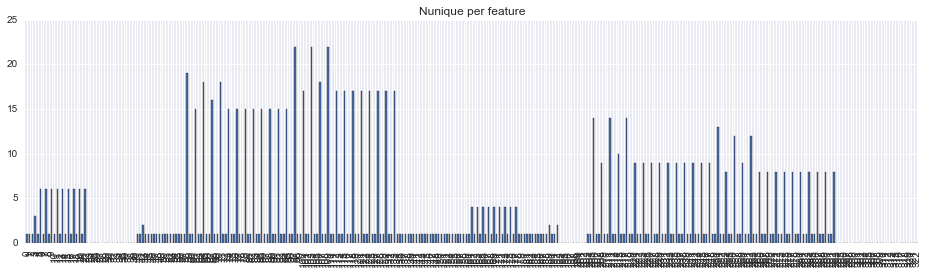

In [188]:
# Figure below plots number of unique levels for each feature order by line & station. As can be seen, the categorical
# features might be similar per station
cat_info[cat_info.line==0].sort_values(['station','feature_nr'])['nunique'].plot(kind='bar', 
                                                                                 figsize=(16,4), 
                                                                                 title='Nunique per feature for line 0')

Station 0 has no data
Station 5 has no data
Station 7 has no data
Station 8 has no data
Station 12 has no data
Station 13 has no data
Station 17 has no data
Station 19 has no data
Station 20 has no data
Station 33 has no data
Station 34 has no data
Station 37 has no data
Station 40 has no data
Station 41 has no data
Station 45 has no data
Station 48 has no data


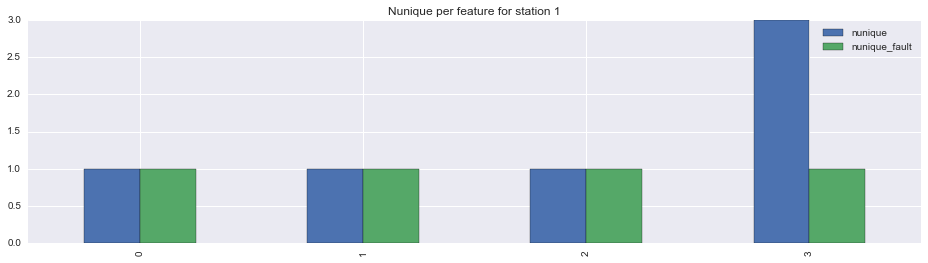

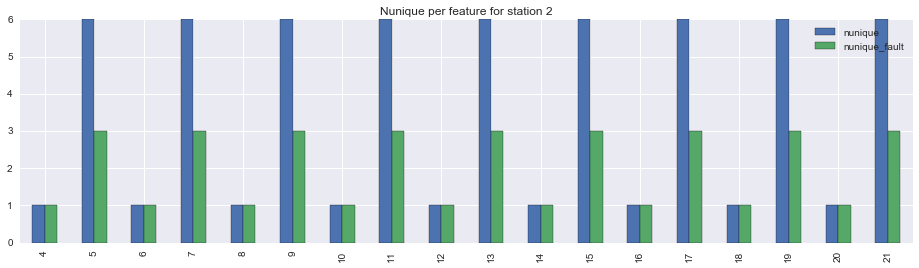

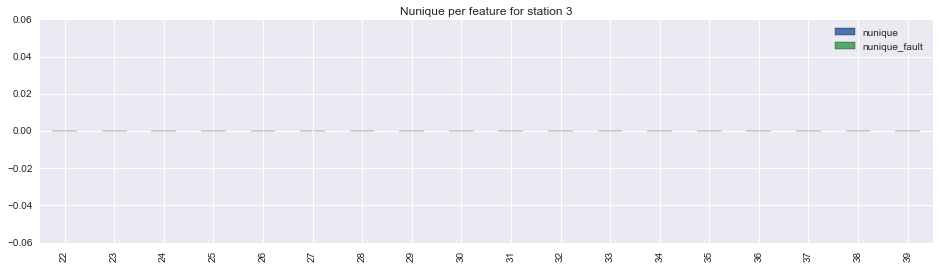

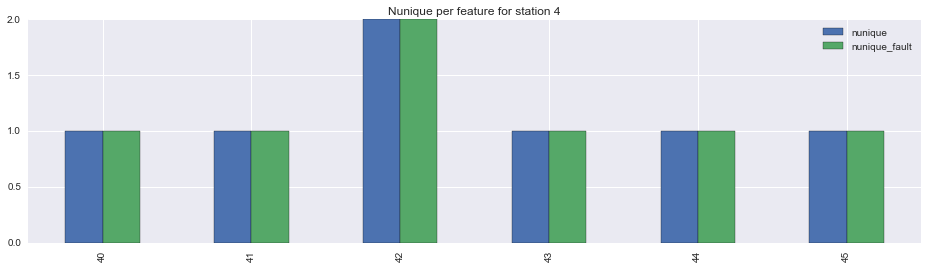

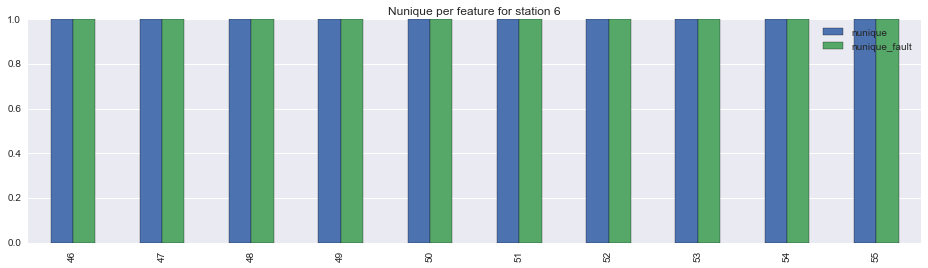

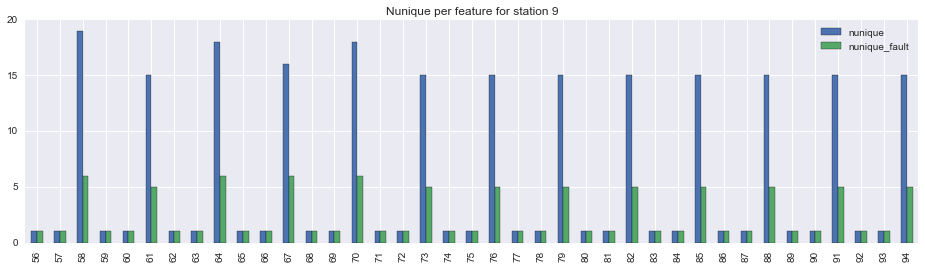

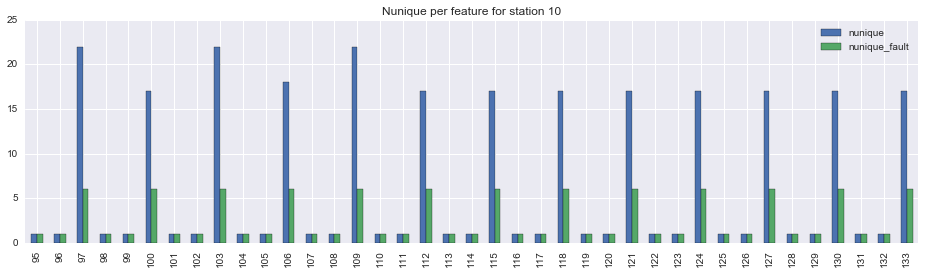

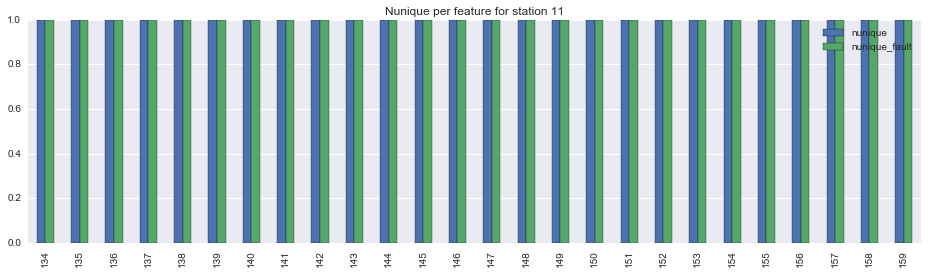

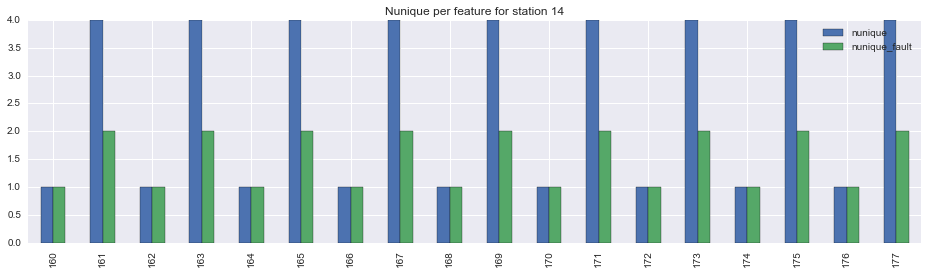

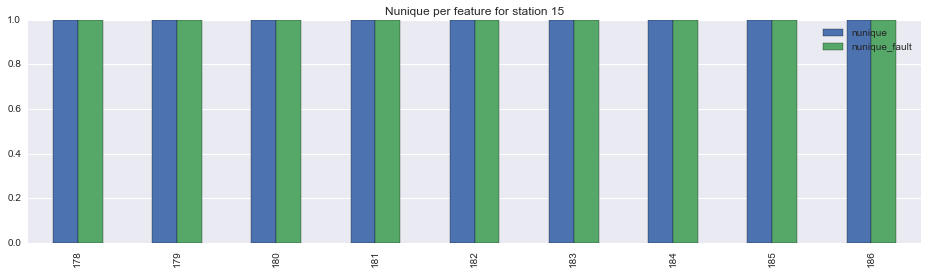

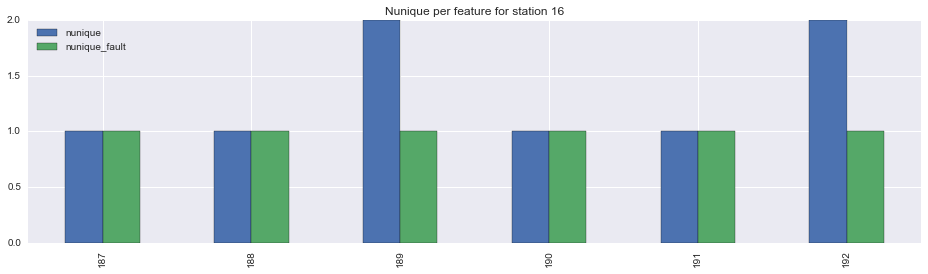

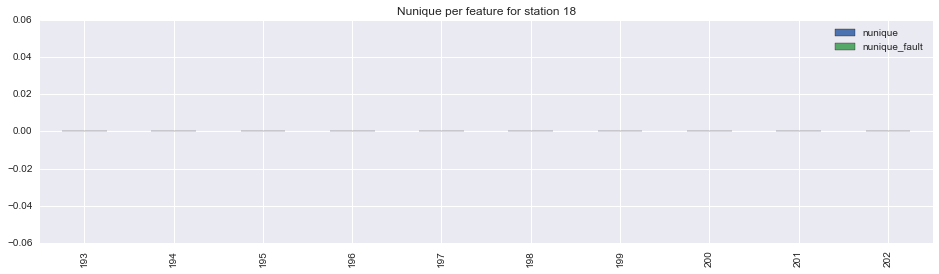

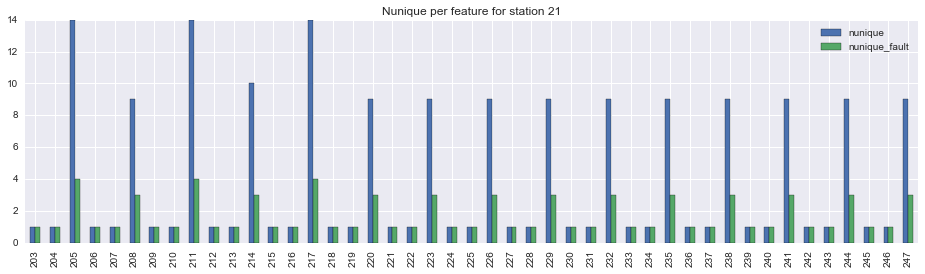

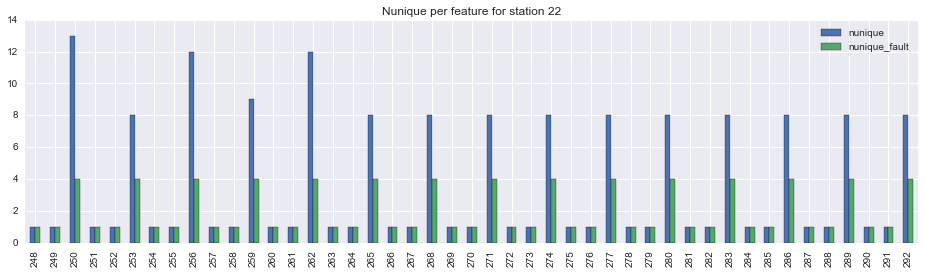

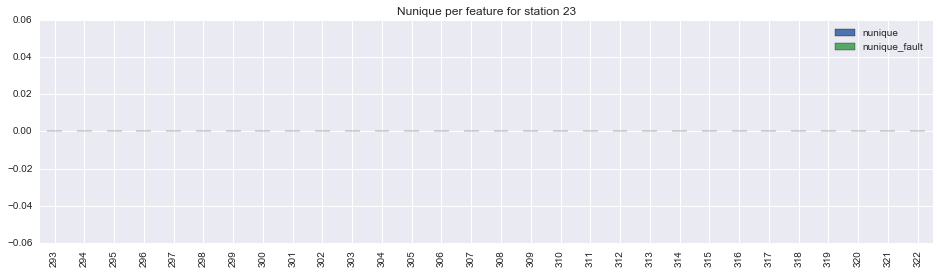

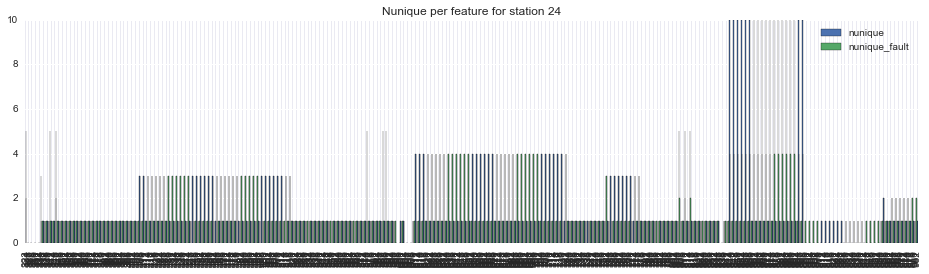

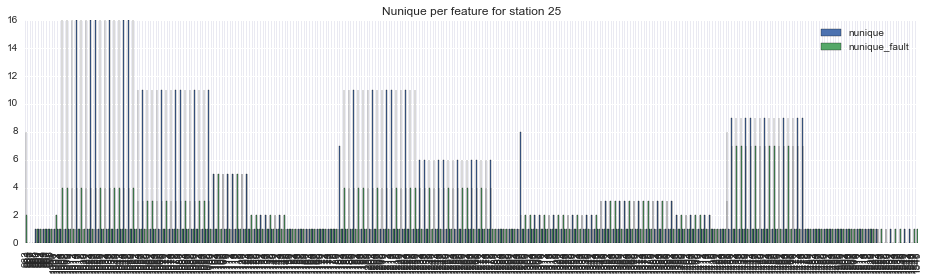

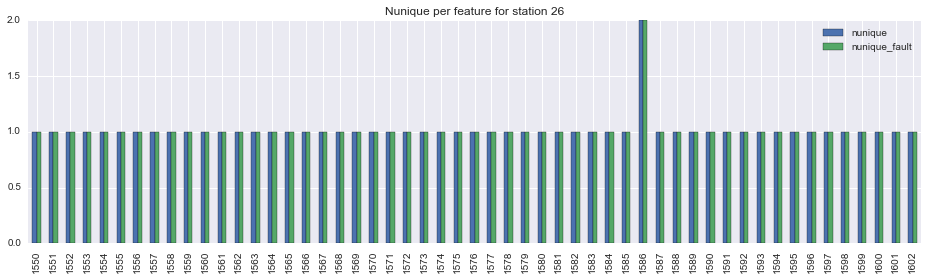

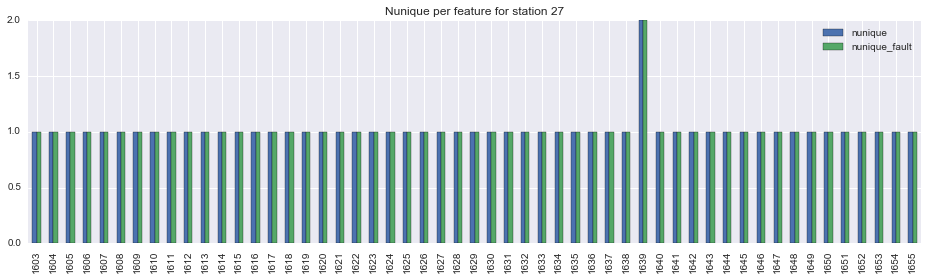

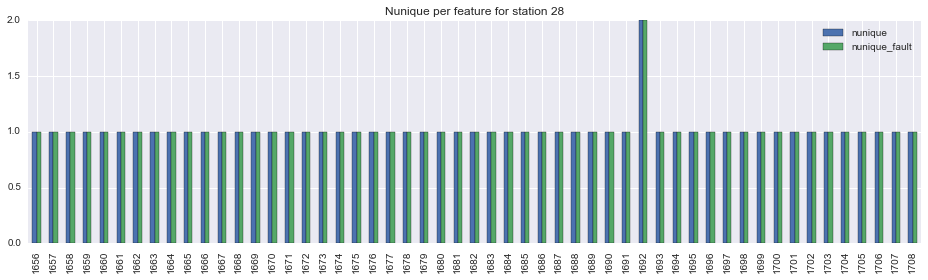

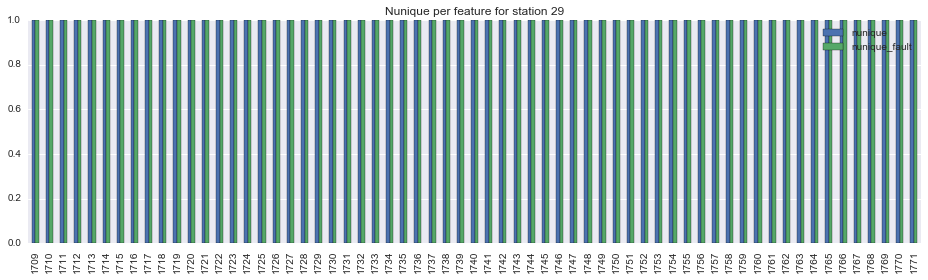

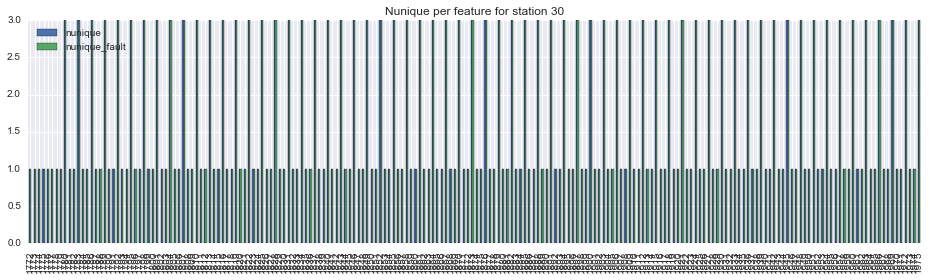

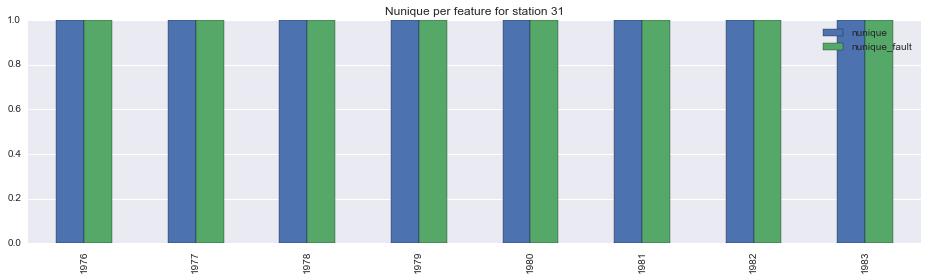

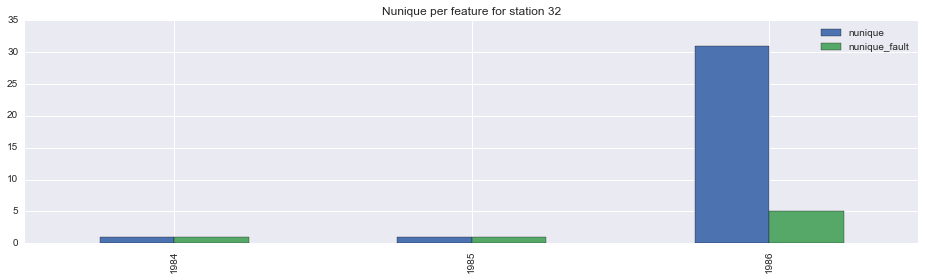

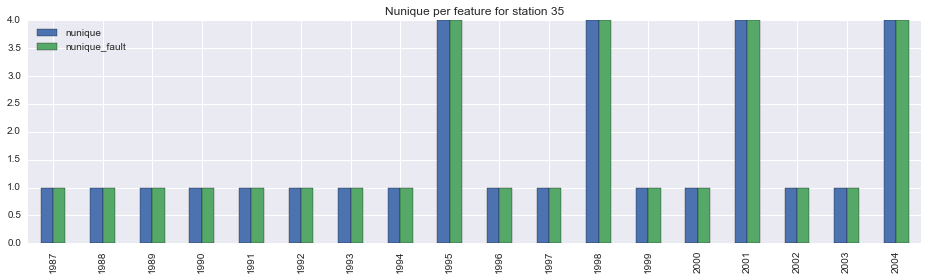

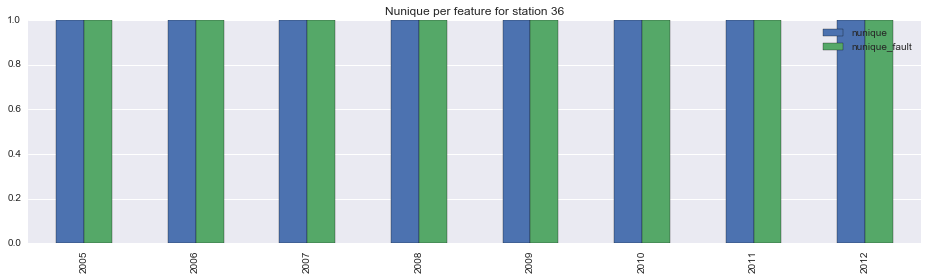

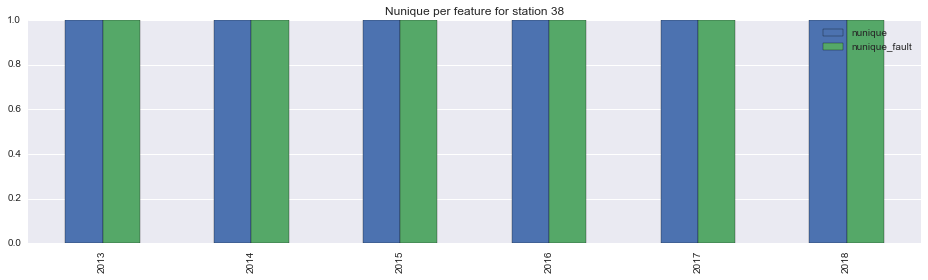

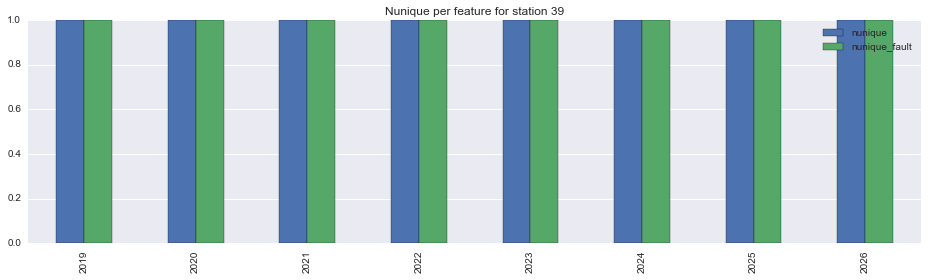

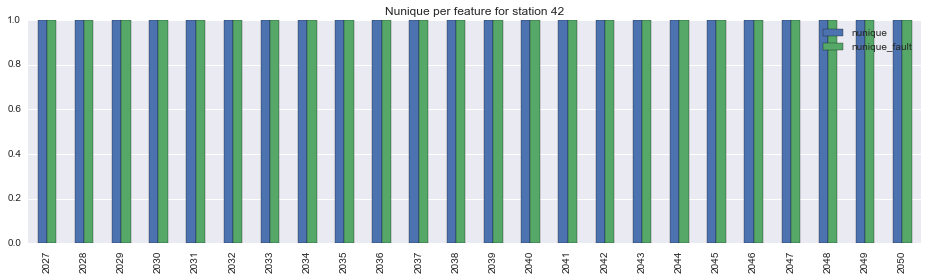

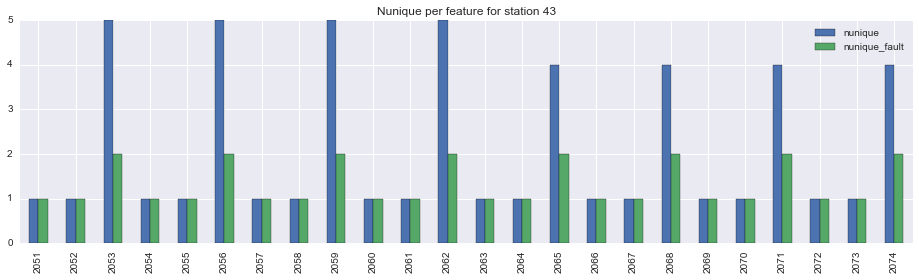

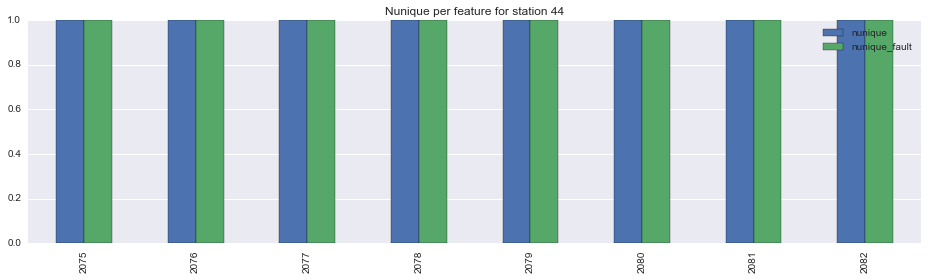

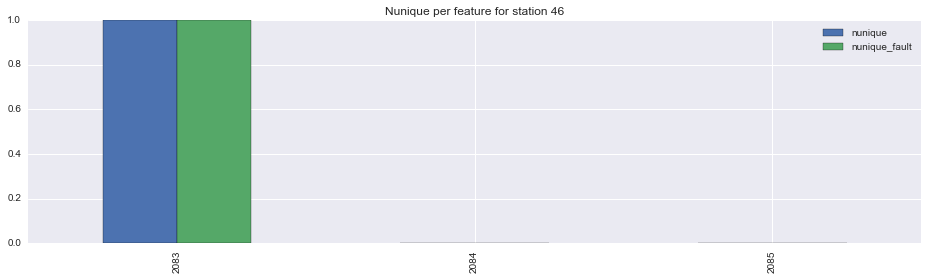

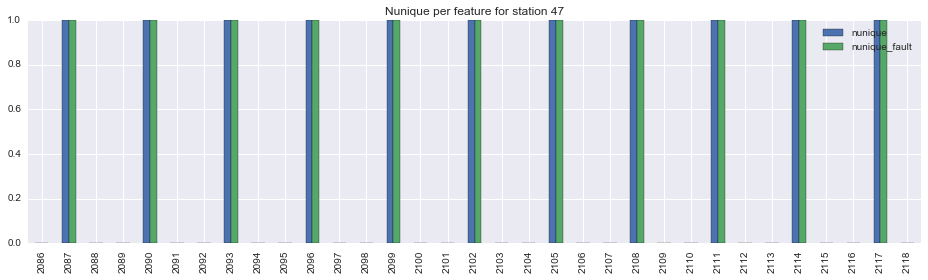

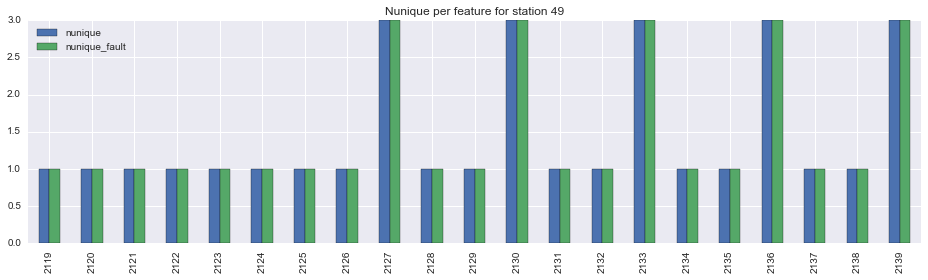

In [202]:
for i in range(50):
    plt.figure()
    if cat_info[cat_info.station==i].shape[0]>0:
        cat_info[cat_info.station==i].sort_values(['feature_nr'])[['nunique','nunique_fault']].plot(kind='bar', 
                                                                                 figsize=(16,4), 
                                                                                 title='Nunique per feature for station {}'.format(i))
    else:
        print('Station {} has no data'.format(i))

In [199]:
for i in range(50):
    if cat_info[cat_info.station==i].shape[0]>0:
        print('Station {} info:'.format(i))
        cat_info[cat_info.station==i]['unique'].apply(lambda x: print(x))

Station 1 info:
[ 1.]
[ 9.]
[ 1.]
[  9.  24.  48.]
Station 2 info:
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
[ 1.]
[  32.   48.   96.   64.  128.    4.]
Station 3 info:
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Station 4 info:
[ 1.]
[ 1.]
[ 97.  98.]
[ 1.]
[ 1.]
[ 98.]
Station 6 info:
[ 1.]
[ 16.]
[ 1.]
[ 16.]
[ 1.]
[ 16.]
[ 1.]
[ 16.]
[ 1.]
[ 16.]
Station 9 info:
[ 1.]
[ 1.]
[  8.00000000e+00   4.00000000e+00   4.85760000e+04   5.12000000e+02
   1.67772480e+07   9.60000000e+01   4.80000000e+01   1.67772320e+07
   1.67775570e+07   1.28000000e+02   3.20000000e+01   1.25829120e+07
   6.55360000e+04   6.55300000e+03   1.67794280e+07   1.67774720e+07
   1.60000000e+01   3.3

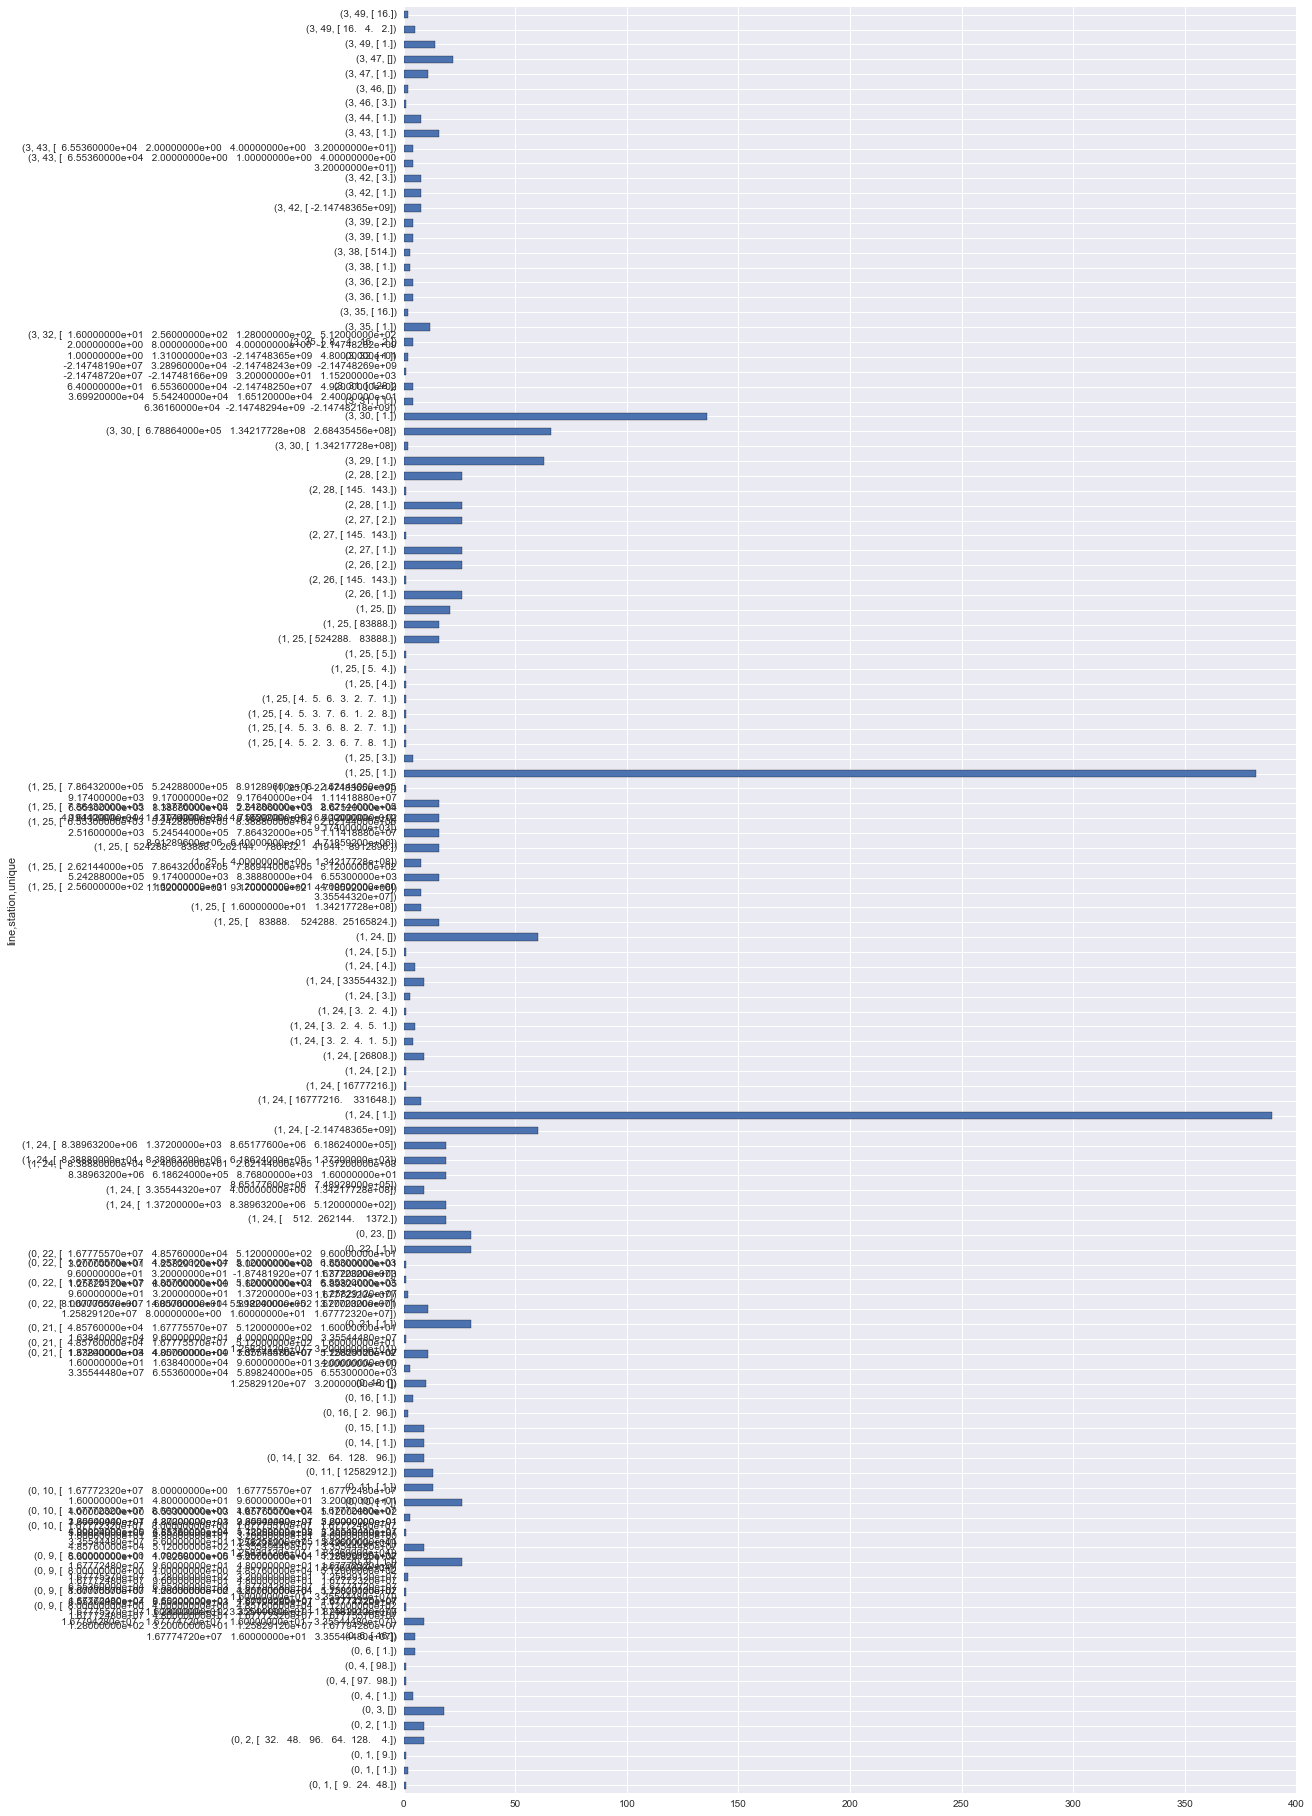

In [209]:
cat_info.groupby(['line','station','unique'])['name'].agg('count').plot(kind='barh', figsize=(16,32))

In [186]:
cat_info.groupby(['line','station'])['val_most_common'].agg(['std', 'count'])

std  count
line station                     
0    1        4.618802e+00      4
     2        1.594937e+01     18
     3                 NaN      0
     4        5.009058e+01      6
     6        7.905694e+00     10
     9        3.342968e+00     39
     10       8.012251e+06     39
     11       6.416051e+06     26
     14       3.241323e+01     18
     15       0.000000e+00      9
     16       5.163978e-01      6
     18                NaN      0
     21       2.315722e+04     45
     22       7.998386e+06     45
     23                NaN      0
1    24       6.460147e+08    600
     25       9.339563e+07    546
2    26       1.971758e+01     53
     27       1.971758e+01     53
     28       1.971758e+01     53
3    29       0.000000e+00     63
     30       1.010122e+08    204
     31       6.788435e+01      8
     32       7.332349e+01      3
     35       4.788330e+00     18
     36       5.345225e-01      8
     38       2.809817e+02      6
     39       5.345225e-01      8
     42       1.034107e+09     24
     43       3.155795e+04     24
     44       0.000000e+00      8
     46                NaN      1
     47       0.000000e+00     11
     49       7.245688e+00     21

In [210]:
cat_info_agg = cat_info.drop(['unique','unique_fault'], axis=1).groupby(['line','station']).agg('mean') 

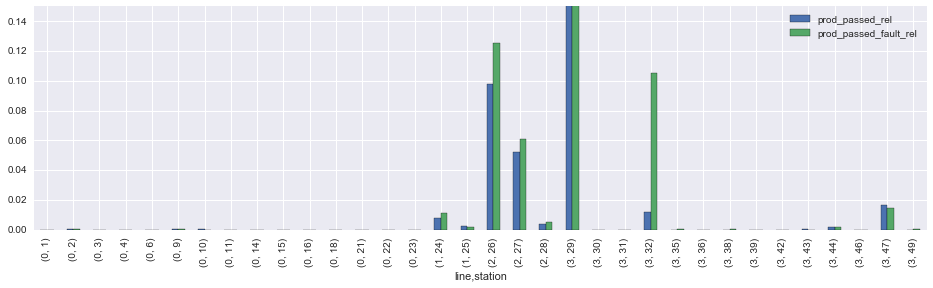

In [214]:
# The plot below shows the relative amount of faulty and non-faulty products that passed this station. Mostly equal,
# but Station 32 on line 3 is interesting. This means the almost all products that passed this station are faulty.
# Couple of stations have higher ratio.
cat_info_agg[['prod_passed_rel','prod_passed_fault_rel']].plot(kind='bar', figsize=(16,4), ylim=[0,0.15])

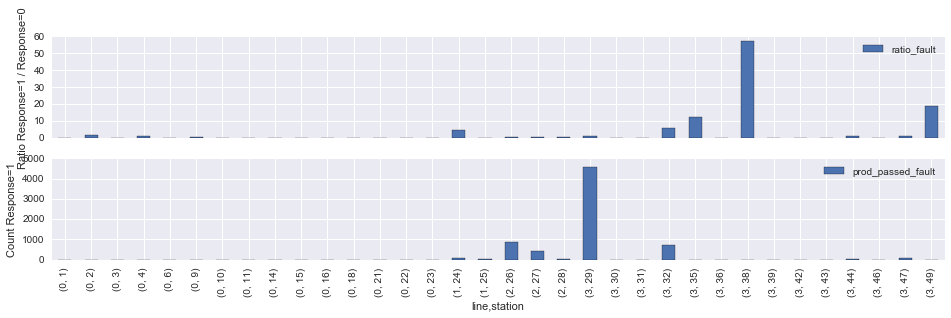

In [216]:
# Next plot shows the ratio of faulty versus non-faulty products. One station looks different...
f, (ax1, ax2) = plt.subplots(2,1,figsize=(16,4), sharex=True)
cat_info_agg[['ratio_fault']].plot(kind='bar', figsize=(16,4), ax=ax1)
ax1.set_ylabel('Ratio Response=1 / Response=0')
cat_info_agg[['prod_passed_fault']].plot(kind='bar', figsize=(16,4), ax=ax2)
#ax2.set_ylim([0,150])
ax2.set_ylabel('Count Response=1')

### Save data

In [220]:
print(cat_info.columns.values)

['line' 'station' 'feature_nr' 'name' 'nunique' 'nunique_fault' 'unique'
 'unique_fault' 'val_most_common' 'val_most_common_fault' 'nunique_diff'
 'same_most_common' 'prod_passed' 'prod_passed_rel' 'prod_passed_fault'
 'prod_passed_fault_rel' 'ratio_fault' 'different_most_common']


In [227]:
column_info = {'line': 'line number',
               'station': 'station number',
             'feature_nr': 'feature number',
              'name': 'feature name',
              'nunique': 'number of unique levels for all samples',
              'nunique_fault': 'number of unique level for samples with Response 1',
               'unique':'string with unique levels for all samples',
               'unique_fault': 'string with unique levels for samples with Response 1',
               'val_most_common': 'most common level all samples',
               'val_most_common_fault': 'most common level for samples with Response 1',
               'nunique_diff': 'difference in number of unique levels',
               'different_most_common': 'boolean whether samples with Reponse = 1 have different most common level',
               'same_most_common': 'boolean whether samples with Reponse = 1 have same most common level',
               'prod_passed': 'number of samples that have value',
               'prod_passed_fault': 'number of samples with Response = 1 that have value',
               'prod_passed_rel': 'relative number of samples that have value',
               'prod_passed_fault_rel': 'relative number of samples with Response = 1 that have value',
               'ratio_fault': 'ratio between prod_passed_fault_rel and prod_passed_rel'}

meta = {'script': 'eda_categorical_per_line_station.ipnb',
        'description': column_info}

In [229]:
cat_info.to_csv(os.path.join(const.DATA_PATH, 'eda_cat_info.csv'), index=False)

In [228]:
func.write_meta_info(os.path.join(const.DATA_PATH, 'eda_cat_info.log'), meta)